In [13]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import src.helpers.model_helpers as mh
import joblib
import os
import sys
import src.helpers.feature_engineering_helper as feh
import src.helpers.logistic_regression_helpers as lrh
import numpy as np

# Finding the root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [15]:
# Log transform skewed continuous features prior to scaling
X_train = feh.log_transform_skewed_features(X_train)
X_test = feh.log_transform_skewed_features(X_test)

# Scale numeric features prior to training
lrh.scale_dataset(X_train)
lrh.scale_dataset(X_test)

,loan_amount,income,combined_loan_to_value_ratio,loan_term,intro_rate_period,prepayment_penalty_term,property_value,loan_to_income_ratio,debt_to_income_ratio_60100_x_loan_to_income_ratio,debt_to_income_ratio_5060_x_loan_to_income_ratio,debt_to_income_ratio_4850_x_loan_to_income_ratio,debt_to_income_ratio_4547_x_loan_to_income_ratio
4048597,0.531789,0.076205,0.325896,0.375900,-0.266993,0.075081,0.035049,0.573047,-0.272492,-0.318270,-0.283584,-0.301347
5573908,0.314341,-0.372218,0.700523,0.375900,-0.266993,0.075081,-0.506020,0.792763,3.794179,-0.318270,-0.283584,-0.301347
2074066,-0.078076,-0.160420,-0.583604,-0.452268,-0.266993,0.075081,0.884289,0.140874,-0.272492,3.044946,-0.283584,-0.301347
4749255,1.195145,0.177574,0.700523,0.375900,-0.266993,0.075081,0.692219,1.203346,-0.272492,-0.318270,-0.283584,-0.301347
5863718,0.354053,0.114174,0.301038,0.003365,-0.266993,0.075081,-0.506020,0.337495,-0.272492,3.124912,-0.283584,-0.301347
...,...,...,...,...,...,...,...,...,...,...,...,...
4059493,-0.526748,-1.151858,0.852714,0.375900,-0.266993,0.075081,-1.551868,0.669526,-0.272492,-0.318270,-0.283584,-0.301347
7224571,-0.140138,0.565258,-1.124668,0.375900,-0.266993,0.075081,1.790152,-0.670163,3.127327,-0.318270,-0.283584,-0.301347
8489849,-0.078076,0.026789,0.298504,-0.452268,-0.266993,0.075081,-0.270869,-0.051094,-0.272492,-0.318270,-0.283584,-0.301347
3149049,-0.353673,1.120435,0.382068,-1.039043,-0.266993,0.075081,1.019980,-1.471536,-0.272492,-0.318270,-0.283584,-0.301347


In [16]:
# Create logistic regression search without PCA
search_without_pca = lrh.create_cv_search()
base_log_reg = lrh.create_base_estimator()

search_without_pca.fit(X_train, y_train)

,estimator,"LogisticRegre...a', tol=0.001)"
,param_distributions,"{'C': <scipy.stats....t 0x1ac2222c0>, 'class_weight': [None, 'balanced'], 'l1_ratio': <scipy.stats....t 0x12ba70dd0>}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [17]:
# Apply PCA / SVD
ipca = joblib.load(os.path.join(project_root, "models", "ipca.pkl"))
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term',
                'property_value', 'loan_to_income_ratio', 'debt_to_income_ratio_60100_x_loan_to_income_ratio', 'debt_to_income_ratio_5060_x_loan_to_income_ratio', 'debt_to_income_ratio_4850_x_loan_to_income_ratio', 'debt_to_income_ratio_4547_x_loan_to_income_ratio']

X_train_numeric = X_train[numeric_cols]
X_test_numeric  = X_test[numeric_cols].to_numpy()

# Transform numeric cols
X_train_numeric_pca = ipca.transform(X_train_numeric)
X_test_numeric_pca  = ipca.transform(X_test_numeric)

# SVD
svd = joblib.load(os.path.join(project_root, "models", "svd.pkl"))
categorical_cols = [col for col in X_train.columns if col not in numeric_cols]
X_train_cat = X_train[categorical_cols]
X_test_cat  = X_test[categorical_cols].to_numpy()

X_train_cat_svd = svd.transform(X_train_cat)
X_test_cat_svd  = svd.transform(X_test_cat)


# Combined transformed with cat again
X_train_pca = np.hstack([X_train_numeric_pca, X_train_cat_svd])
X_test_pca  = np.hstack([X_test_numeric_pca,  X_test_cat_svd])

/Users/c1burns/Documents/UTD/BUAN 6341/project_repo/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but IncrementalPCA was fitted with feature names
  warnings.warn(
/Users/c1burns/Documents/UTD/BUAN 6341/project_repo/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


In [18]:
# Create logistic regression search with PCA
search_with_pca = lrh.create_cv_search()

search_with_pca.fit(X_train_pca, y_train)

,estimator,"LogisticRegre...a', tol=0.001)"
,param_distributions,"{'C': <scipy.stats....t 0x10ece8c00>, 'class_weight': [None, 'balanced'], 'l1_ratio': <scipy.stats....t 0x1ac176140>}"
,n_iter,30
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [19]:
# Calculate F1 for validation
print("Without PCA")
mh.output_cv_summary(search_without_pca)

print("With PCA")
mh.output_cv_summary(search_with_pca)

Without PCA
Best params: {'C': np.float64(33.981724150105975), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.5704439744053994)}
Best CV F1: 0.6503819603891338
With PCA
Best params: {'C': np.float64(42.78743516759822), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.18182496720710062)}
Best CV F1: 0.5286432745437554


In [20]:
# Calculate metrics with and without PCA
results, y_pred, y_prob = mh.calculate_test_metrics(search_without_pca, X_test, y_test)
results_pca, y_pred_pca, y_prob_pca = mh.calculate_test_metrics(search_with_pca, X_test_pca, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results_pca, "log_reg_metrics_csv")

# Display metrics
print("Test Performance (Without PCA):")
display(results)
print("Test Performance (With PCA):")
display(results_pca)

Best threshold = 0.5829145728643216, F1 = 0.6756508422664624
Best threshold = 0.5226130653266332, F1 = 0.5514295103516267
Test Performance (Without PCA):


,Score
F1,0.675651
Accuracy,0.840296
Precision,0.657330
Recall,0.695022
ROC AUC,0.874020
PR AUC,0.760431


Test Performance (With PCA):


,Score
F1,0.551430
Accuracy,0.794149
Precision,0.576236
Recall,0.528670
ROC AUC,0.790531
PR AUC,0.638696


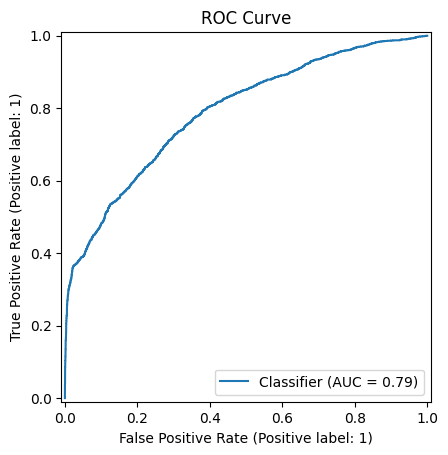

In [21]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob_pca, "log_reg_roc")

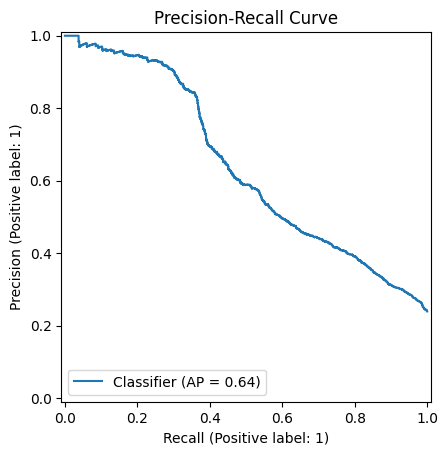

In [22]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob_pca, "log_reg_pr")

In [23]:
# Persist fitted model
mh.persist_model(search_with_pca, "log_reg_model")

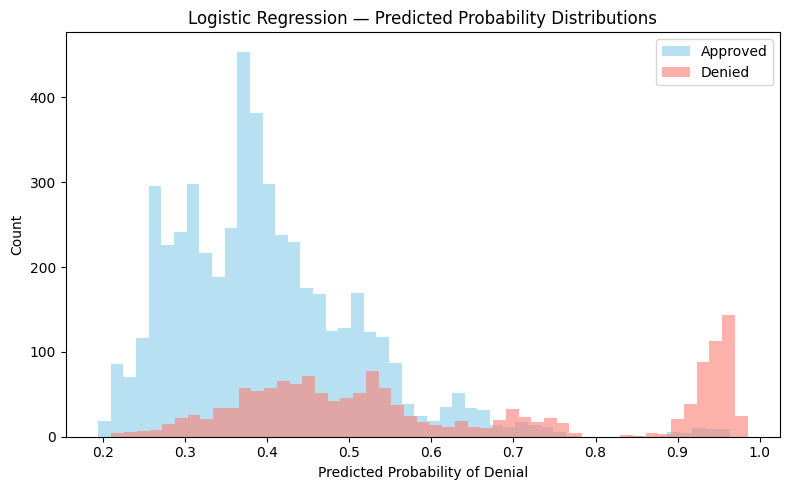

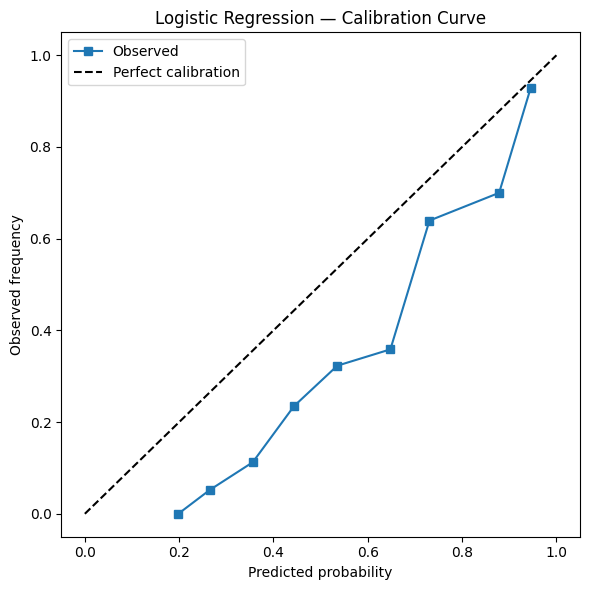

In [24]:
# Plot diagnostic charts to see how to further optimize model
mh.plot_probability_distributions(y_test, y_prob_pca, "Logistic Regression")
mh.plot_calibration_curve(y_test, y_prob_pca, "Logistic Regression")